In [10]:
import os
os.environ['USE_PYGEOS'] = '0'
import shap
import pandas as pd
from pycaret.regression import *
import numpy as np
np.bool = np.bool_

# Modeling

To model the data, Pycaret was used as it has the ability to run a wide range of models on the dataset to find the best one automatically. 

For the sample dataset, only the ratio and percentage features were used in the modeling in order to lessen the risks of multicollinerity. 

The first step is to load the sample data

In [2]:
sample_dataset = pd.read_csv('data/sample_dataset.csv')
sample_dataset.head(2)

hex_8_id  M/F Ratio  age <10 M/F Ratio  age <10 % of Total   
0  881870d241fffff   0.928957           1.082825            0.136035  \
1  881870daa5fffff   0.900940           1.010307            0.075798   

   age 10-19 M/F Ratio  age 10-19 % of Total  age 20-34 M/F Ratio   
0             0.953876              0.111560             0.914051  \
1             1.060049              0.101246             1.081547   

   age 20-34 % of Total  age 35-49 M/F Ratio  age 35-49 % of Total   
0              0.182287             0.958037              0.176763  \
1              0.107383             0.858200              0.158404   

   age 50-64 M/F Ratio  age 50-64 % of Total  age >=65 M/F Ratio   
0             0.987712              0.177049            0.781442  \
1             0.885538              0.217600            0.816219   

   age >=65 % of Total  accidents_per_capita  
0             0.216307              0.011398  
1             0.339569              0.003655

In [3]:
sample_dataset = sample_dataset[['M/F Ratio', 'age <10 M/F Ratio', 'age <10 % of Total',
       'age 10-19 M/F Ratio', 'age 10-19 % of Total', 'age 20-34 M/F Ratio',
       'age 20-34 % of Total', 'age 35-49 M/F Ratio', 'age 35-49 % of Total',
       'age 50-64 M/F Ratio', 'age 50-64 % of Total', 'age >=65 M/F Ratio',
       'age >=65 % of Total', 'accidents_per_capita']]

In [4]:
setup(sample_dataset, target='accidents_per_capita', normalize_method='robust', normalize=True, session_id=123)

In [5]:
best_model = compare_models()

In [6]:
final_model = create_model(best_model)

## SHAP plots

A special function was made to get the absolute mean SHAP values

In [7]:
def ABS_SHAP(shap_values, X_train):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(shap_values)
    feature_list = X_train.columns
    shap_v.columns = feature_list
    df_v = X_train.copy().reset_index().drop('index',axis=1)

    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'blue','red')

    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Blue = Positive Impact)")

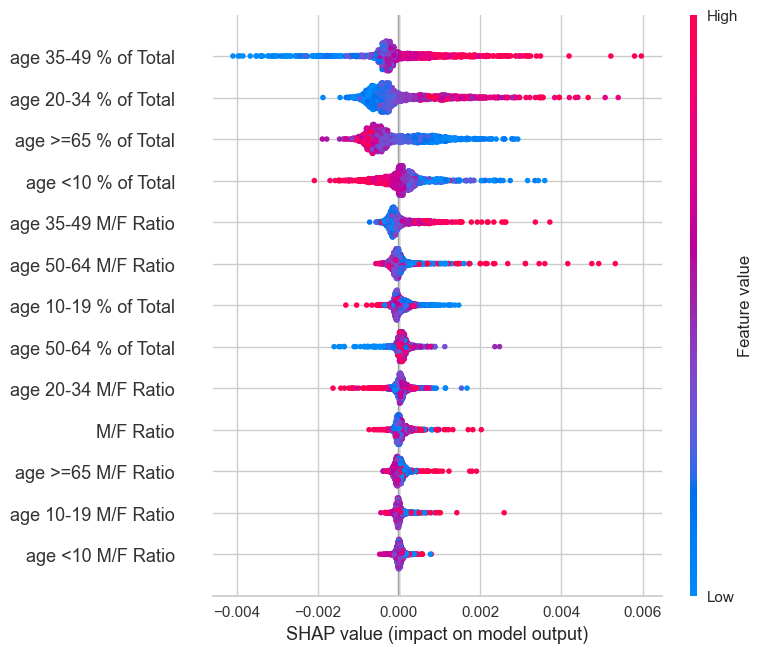

In [8]:
interpret_model(final_model)

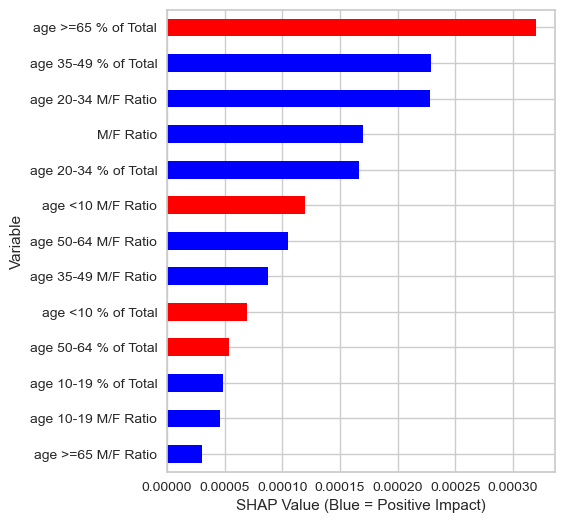

In [9]:
X_train = get_config('X_train')
shap_values = shap.TreeExplainer(final_model).shap_values(X_train)

ABS_SHAP(shap_values, X_train)